# Figure 2

This notebook generates the plots for figure 2

- A) Histogram of SOCAT pCO2observations in 1980s, 1990s, 2000s and 2010sshown by different shades of gray.  Dotted line indicates mean pCO2.  
- B) boxplot of observationsfor each decade.  Whisker indicates 1.5*IQR, observations outside the whisker have been omitted.White line indicates the mean and the number inside in the box indicates the number of observa-tions within that decade.  
- C) Histogram of the difference between CESM model and SOCAT and
- D) is the corresponding boxplot.  Due to different internal model structures, the long-term trendfrom 1980s to 2010s varies from -7μatm to +9μatm.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
%config InlineBackend.print_figure_kwargs = {'dpi':300, 'bbox_inches': 'tight'}

import numpy as np
import pandas as pd
import xarray as xr
import xarray.ufuncs as xu
import cmocean as cm
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import AutoMinorLocator
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import os
import glob 

# Makes world maps
from plotting_tools.spatial_map import SpatialMap
from plotting_tools.time_series_diagram import TimeSeriesPlot
from plotting_tools.utils import xr_add_cyclic_point

import seaflux

# 1. Load data

## 1.1 Load GCB models

In [3]:
ds_mod = xr.open_dataset('/home/gloege/projects/ldeo_hpd/data/simulations/GCB2019-spco2_1x1_mon_198201-201812.nc')

models = [ 'cesm_spco2_1x1_A', 
           'recom_jra_spco2_1x1_A', 
           'mpi_spco2_1x1_A', 
           'cnrm_spco2_1x1_A',
           'noresm_spco2_1x1_A',
           'planktom_spco2_1x1_A',
           'princeton_spco2_1x1_A',
           'csiro_spco2_1x1_A',
           'ipsl_spco2_1x1_A']

# initialize
ds_mod['model_avg'] = ds_mod['cesm_spco2_1x1_A']*0

# add all the models
for mod in models:
    ds_mod['model_avg'] +=  ds_mod[mod]
    
# average models
ds_mod['model_avg'] =  ds_mod['model_avg']/len(models)

## 1.2 Load SOCAT

In [2]:
# Load SOCAT
dir_raw = '/local/data/artemis/observations'
ds_soc = xr.open_dataset(f'{dir_raw}/SOCAT/originals/SOCATv2019_tracks_gridded_monthly.nc')
ds_soc = ds_soc.rename({'xlon':'lon', 'ylat':'lat', 'tmnth':'time'})

# time range
date_range = ['1982-01', '2016-12']
ds_soc = ds_soc.sel(time=slice(f'{date_range[0]}',f'{date_range[1]}'))
ds_soc['time'] = pd.date_range(start=f'{date_range[0]}T00:00:00.000000000', 
                      end=f'{date_range[1]}T00:00:00.000000000',freq='MS')+ np.timedelta64(14, 'D')

# convert fco2 to pco2
ds_soc['pco2_ave_unwtd'] = xr.apply_ufunc(
    seaflux.fCO2_to_pCO2, 
    ds_soc['fco2_ave_unwtd'], 
    ds_soc['sst_ave_unwtd'])

# roll longitude
ds_soc = ds_soc.roll(lon=180, roll_coords='lon')
ds_soc['lon'] = np.arange(0.5,360,1)

# SOCAT Mask
#ds_mask = xr.open_dataset(f'{dir_raw}/SOCAT/SOCATv5_mask_198201-201701.nc')
#ds_mask = ds_mask.rename({'xlon':'lon', 'ylat':'lat'})

# Number of months with obervations
#nmonths = (ds['fco2_ave_unwtd'] > 0).sum('time')
#nmonths = nmonths.where(nmonths>0)

/home/gloege/.conda/envs/tensorflow/lib/python3.7/site-packages/seaflux/check_units.py:258: RuntimeWarning: invalid value encountered in less
  outside = (arr < lims[0]) | (arr > lims[1])
/home/gloege/.conda/envs/tensorflow/lib/python3.7/site-packages/seaflux/check_units.py:258: RuntimeWarning: invalid value encountered in greater
  outside = (arr < lims[0]) | (arr > lims[1])


In [64]:
mask = (ds_soc['pco2']>0)*1

## 1.2.1 OLD LOAD SOCAT

In [ ]:
# Load SOCAT
dir_raw = '/local/data/artemis/observations'
ds_soc = xr.open_dataset(f'{dir_raw}/SOCAT/originals/SOCATv2019_tracks_gridded_monthly.nc')
ds_soc = ds_soc.rename({'xlon':'lon', 'ylat':'lat', 'tmnth':'time'})

# time range
date_range = ['1982-01', '2016-12']
ds_soc = ds_soc.sel(time=slice(f'{date_range[0]}',f'{date_range[1]}'))
ds_soc['time'] = pd.date_range(start=f'{date_range[0]}T00:00:00.000000000', 
                      end=f'{date_range[1]}T00:00:00.000000000',freq='MS')+ np.timedelta64(14, 'D')

    
# roll longitude
ds_soc = ds_soc.roll(lon=180, roll_coords='lon')
ds_soc['lon'] = np.arange(0.5,360,1)



# Load SOCAT
dir_raw = '/home/gloege/projects/ldeo_hpd/data/interim'
ds_soc = xr.open_dataset(f'{dir_raw}/SOCATv2019-pco2_mon_1x1_198201-201812.nc')

# time range
date_range = ['1982-01', '2018-12']
ds_soc = ds_soc.sel(time=slice(f'{date_range[0]}',f'{date_range[1]}'))
ds_soc['time'] = pd.date_range(
    start=f'{date_range[0]}T00:00:00.000000000', 
    end=f'{date_range[1]}T00:00:00.000000000',
    freq='MS') + np.timedelta64(14, 'D')

## 1.3 model error

In [15]:
ds_error = ds_mod['model_avg'] - ds_soc['pco2']
# 0:  8.79501423
# 1: -3.79679744
# 2: -7.03923594
# 3: -1.48756088
# 4:  3.81913519
# 5:  7.8254382
# 6: -0.93149367
# 7:  6.27836782
# 8: -3.66073657
# model avg: 1.09792341

# 2. SOCAT hitograms

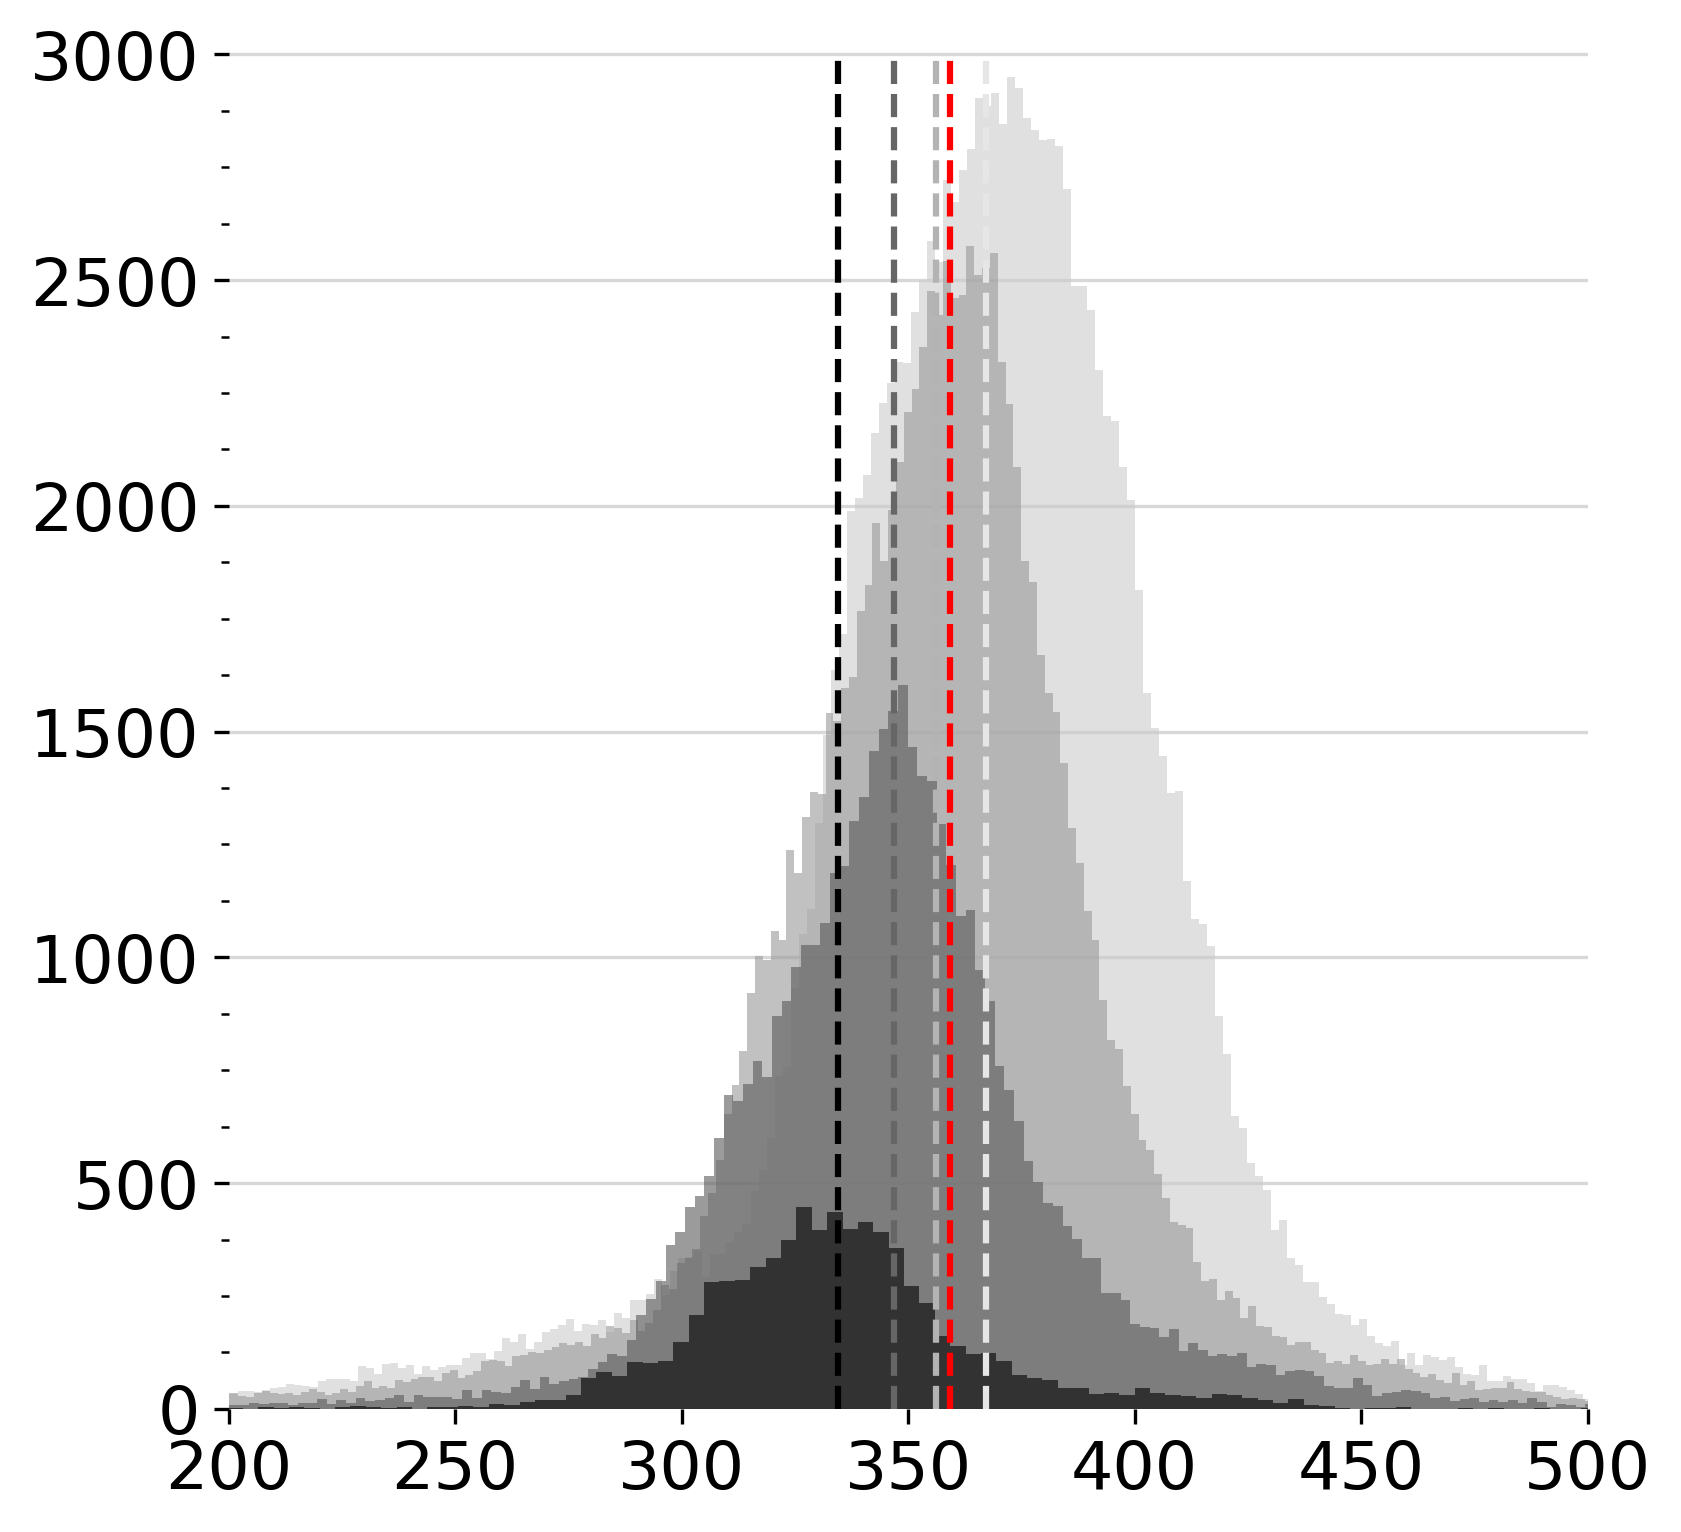

In [7]:
fig = plt.figure(figsize=(6,6)) 
ax = fig.add_subplot(111)

var = 'pco2'
ds_soc_80s = ds_soc[f'{var}'].where((ds_soc[f'{var}']<800))
ds_soc_80s = ds_soc_80s.where((ds_soc['time'].dt.year>=1980) & (ds_soc['time'].dt.year<1990))
df_soc_80s = ds_soc_80s.to_dataframe().reset_index().dropna()

ds_soc_90s = ds_soc[f'{var}'].where((ds_soc[f'{var}']<800))
ds_soc_90s = ds_soc_90s.where((ds_soc['time'].dt.year>=1990) & (ds_soc['time'].dt.year<2000))
df_soc_90s = ds_soc_90s.to_dataframe().reset_index().dropna()

ds_soc_00s = ds_soc[f'{var}'].where((ds_soc[f'{var}']<800))
ds_soc_00s = ds_soc_00s.where((ds_soc['time'].dt.year>=2000) & (ds_soc['time'].dt.year<2010))
df_soc_00s = ds_soc_00s.to_dataframe().reset_index().dropna()

ds_soc_10s = ds_soc[f'{var}'].where((ds_soc[f'{var}']<800))
ds_soc_10s = ds_soc_10s.where((ds_soc['time'].dt.year>=2010) & (ds_soc['time'].dt.year<2020))
df_soc_10s = ds_soc_10s.to_dataframe().reset_index().dropna()


# An "interface" to matplotlib.axes.Axes.hist() method

n, bins, patches = ax.hist(x=df_soc_10s[f'{var}'], bins='auto', color=[0.8,0.8,0.8],
                            alpha=0.6, rwidth=1)

n, bins, patches = ax.hist(x=df_soc_00s[f'{var}'], bins='auto', color=[0.6,0.6,0.6],
                            alpha=0.6, rwidth=1)

n, bins, patches = ax.hist(x=df_soc_90s[f'{var}'], bins='auto', color=[0.35,0.35,0.35],
                            alpha=0.6, rwidth=1)


n, bins, patches = ax.hist(x=df_soc_80s[f'{var}'], bins='auto', color=[0,0,0],
                            alpha=0.6, rwidth=1)


maxfreq = 3000 #n.max()


ax.plot([df_soc_80s[f'{var}'].mean(), df_soc_80s[f'{var}'].mean()],
         [0, maxfreq], color=[0,0,0], linestyle='--')
ax.plot([df_soc_90s[f'{var}'].mean(), df_soc_90s[f'{var}'].mean()],
         [0, maxfreq], color=[0.4,0.4,0.4], linestyle='--')
ax.plot([df_soc_00s[f'{var}'].mean(), df_soc_00s[f'{var}'].mean()],
         [0, maxfreq], color=[0.7,0.7,0.7], linestyle='--')
ax.plot([df_soc_10s[f'{var}'].mean(), df_soc_10s[f'{var}'].mean()],
         [0, maxfreq], color=[0.9,0.9,0.9], linestyle='--')

ax.plot([ds_soc[f'{var}'].where((ds_soc[f'{var}']<800)).mean().values, 
         ds_soc[f'{var}'].where((ds_soc[f'{var}']<800)).mean().values],
         [0, maxfreq], color=[1,0,0], linestyle='--')

#n, bins, patches = plt.hist(x=df_out['pco2_ave_unwtd'], bins='auto', color='red', 
#                            alpha=0.5, rwidth=1)
ax.grid(axis='y', alpha=0.75)
#plt.xlabel('Value')
#plt.ylabel('Frequency')
#plt.title('My Very Own Histogram')
#plt.text(23, 45, r'$\mu=15, b=3$')
# Set a clean upper y-axis limit.
ax.set_ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)
ax.set_xlim(200,500)

# Turn off the display of all ticks.
ax.tick_params(which='both', # Options for both major and minor ticks
                top='off', # turn off top ticks
                left='off', # turn off left ticks
                right='off',  # turn off right ticks
                bottom='off') # turn off bottom ticks

# rotate x tick labels
#plt.setp(ax.get_xticklabels(), rotation=90)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# major/minor tick lines
#ax.minorticks_on()
ax.yaxis.set_minor_locator(AutoMinorLocator(4))
#ax.xaxis.set_minor_locator(AutoMinorLocator(4))
ax.grid(axis='y', which='major', color=[0.8,0.8,0.8], linestyle='-')

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom') #'bottom' 

# Make axis square
x0, x1 = ax.get_xlim()
y0, y1 = ax.get_ylim()
ax.set_aspect(abs(x1-x0)/abs(y1-y0))

# Don't allow the axis to be on top of your data
ax.set_axisbelow(True)

ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)

## 2.1 Means pCO2

In [61]:
ds_soc[f'{var}'].where((ds_soc[f'{var}']<800)).mean().values

array(359.3032109)

## 2.2 difference in means

In [8]:
ds_soc_10s.mean() - ds_soc_80s.mean()

<xarray.DataArray 'pco2' ()>
array(32.67409661)

# 3. Box plot

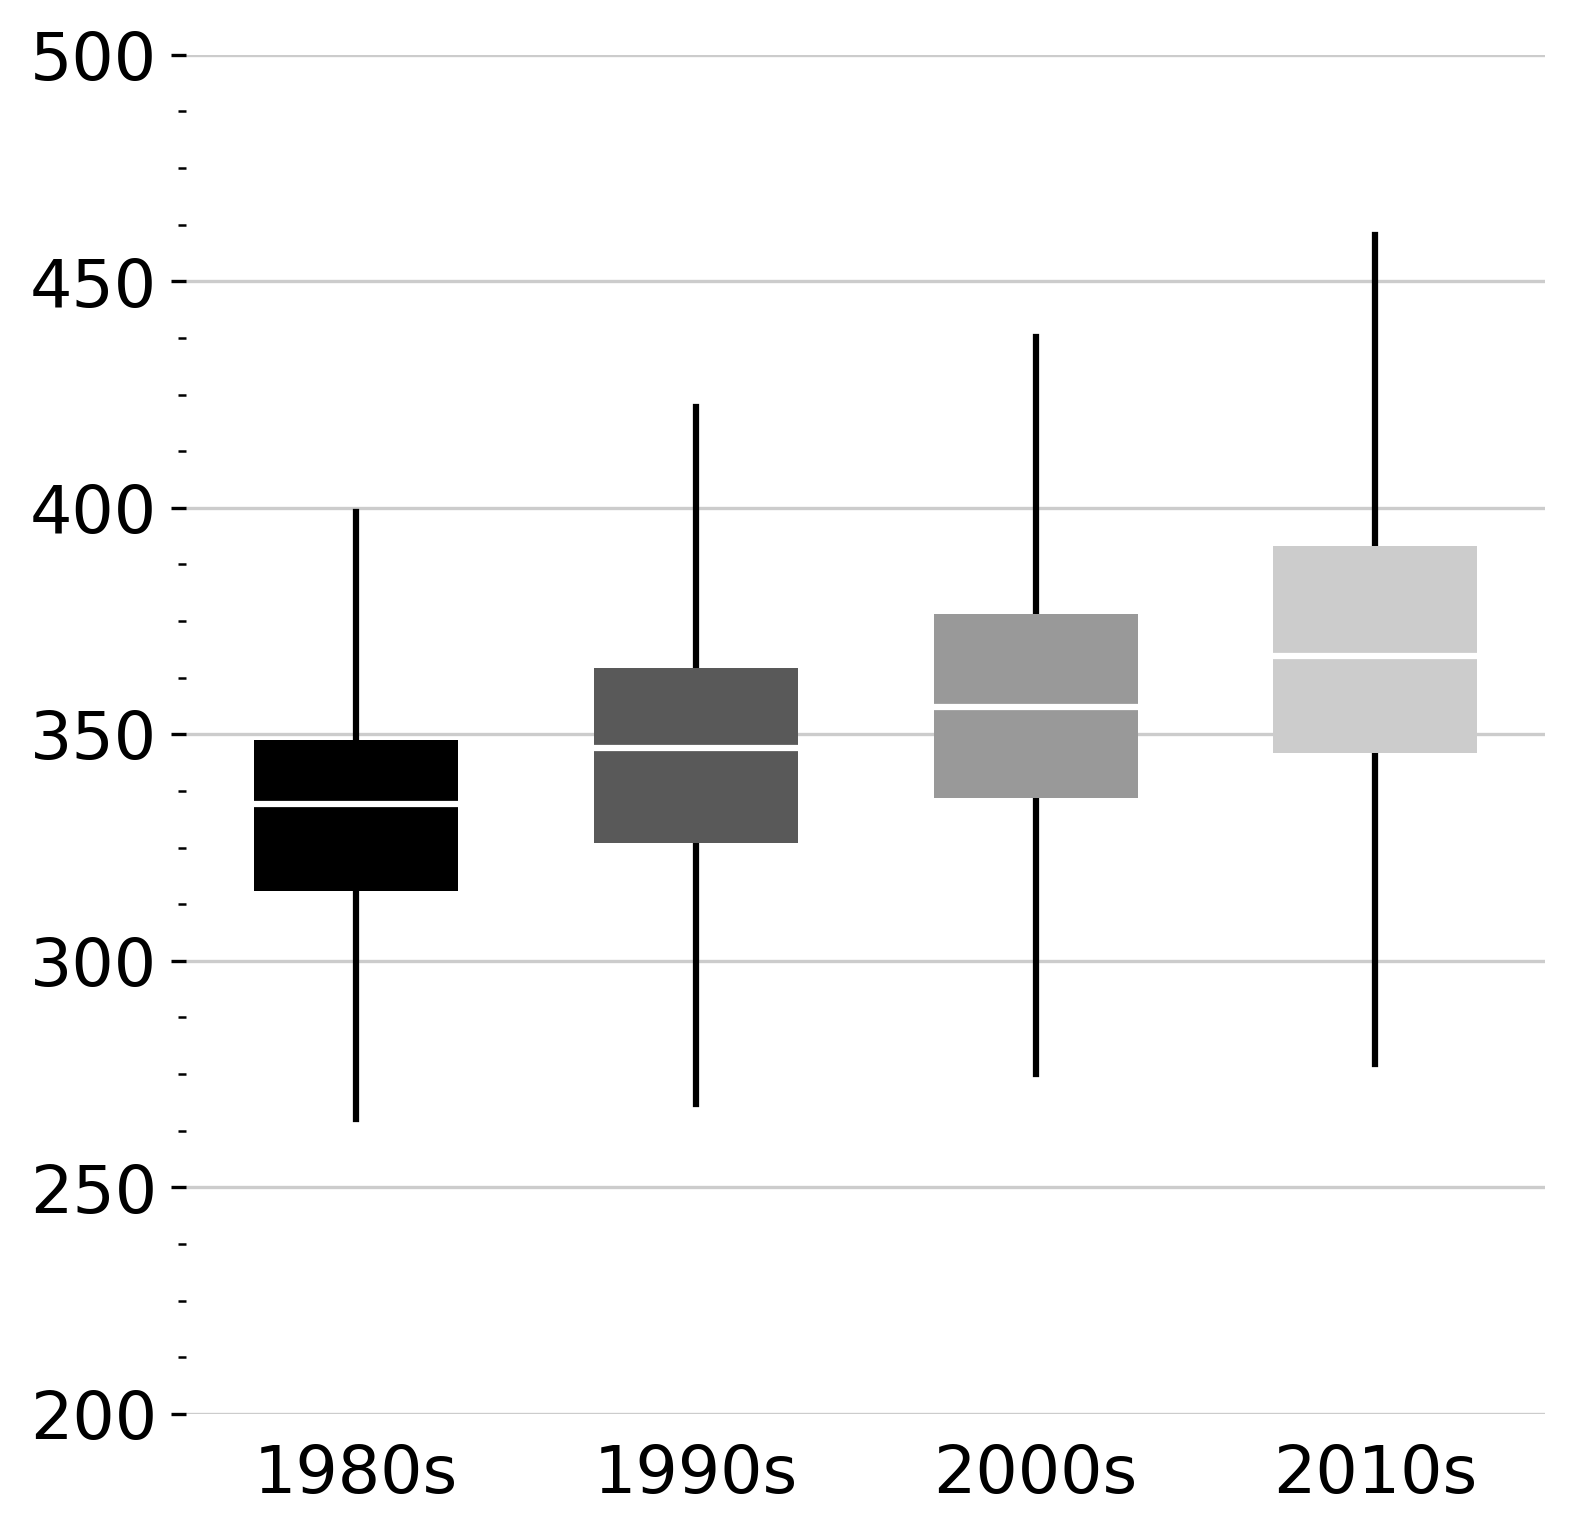

In [12]:
# https://www.delftstack.com/howto/matplotlib/how-to-set-tick-labels-font-size-in-matplotlib/
# https://jonchar.net/notebooks/matplotlib-styling/
# https://cduvallet.github.io/posts/2018/03/boxplots-in-python

# t test: https://www.statology.org/two-sample-t-test-python/
# https://www.machinelearningplus.com/plots/top-50-matplotlib-visualizations-the-master-plots-python/

#with plt.rc_context({'axes.edgecolor':'orange'}):
fig = plt.figure(figsize=(6,6)) 
ax = fig.add_subplot(111)

whiskerprops = {'linewidth':1.5, 'color': [0,0,0]}
boxprops = {'linewidth':0, 'color': [0.5,0.5,0.5]}
flierprops = {'marker':'o', 'markersize':3, 'markeredgecolor':[0.5,0.5,0.5], 'markeredgewidth':0.5}
capprops = {'linewidth':1.5, 'color': [0.5,0.5,0.5]}
meanprops = {'linewidth':1.5, 'linestyle':'-', 'color': [1,1,1], }
medianprops = {'linewidth':0, 'color': [1,1,1],}

params = {
    'x': [df_soc_80s['pco2'], 
          df_soc_90s['pco2'], 
          df_soc_00s['pco2'], 
          df_soc_10s['pco2']],
    'positions': [1,2,3,4],
    'labels': ['1980s','1990s','2000s','2010s'],
    'widths':0.6, 
    'notch':False,
    'whis':1.5,
    'meanline': True, 'showmeans': True,
    'patch_artist':True,
    'whiskerprops': whiskerprops,
    'boxprops': boxprops,
    'capprops': capprops, 'showcaps':False,
    'flierprops':flierprops, 'showfliers':False,
    'medianprops': medianprops,
    'meanprops':meanprops,
    }

bplot = ax.boxplot(**params)

# fill with colors
colors = [
    [0,0,0], 
    [0.35,0.35,0.35], 
   [0.6, 0.6, 0.6],
      [0.8, 0.8, 0.8],
    ]


for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)
        
    
# Range ov axes
ax.set_ylim([200, 500])
#ax.set_xlim([datetime.date(2000, 1, 1), datetime.date(2020, 12, 31)])

# Turn off the display of all ticks.
ax.tick_params(which='both', # Options for both major and minor ticks
                top='off', # turn off top ticks
                left='off', # turn off left ticks
                right='off',  # turn off right ticks
                bottom='off') # turn off bottom ticks

# rotate x tick labels
#plt.setp(ax.get_xticklabels(), rotation=90)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# major/minor tick lines
#ax.minorticks_on()
ax.yaxis.set_minor_locator(AutoMinorLocator(4))
#ax.xaxis.set_minor_locator(AutoMinorLocator(4))
ax.grid(axis='y', which='major', color=[0.8,0.8,0.8], linestyle='-')

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('none') #'bottom' 

# Make axis square
x0, x1 = ax.get_xlim()
y0, y1 = ax.get_ylim()
ax.set_aspect(abs(x1-x0)/abs(y1-y0))

# Don't allow the axis to be on top of your data
ax.set_axisbelow(True)

ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)

# Labels
#ax.set_ylabel(f'LAI', fontsize=16)


#dir_figs = '/rigel/glab/users/ljg2157/projects/heatwave/reports/figures'
#plt.savefig(f'{dir_figs}/boxplots.pdf', 
#                transparent = True, 
#                bbox_inches = 'tight', 
#                pad_inches = 0)

In [17]:
print(f'1980s {len(df_soc_80s)}')
print(f'1990s {len(df_soc_90s)}')
print(f'2000s {len(df_soc_00s)}')
print(f'2010s {len(df_soc_10s)}')

1980s 7664
1990s 46494
2000s 103796
2010s 138468


# 4. Histogram of difference

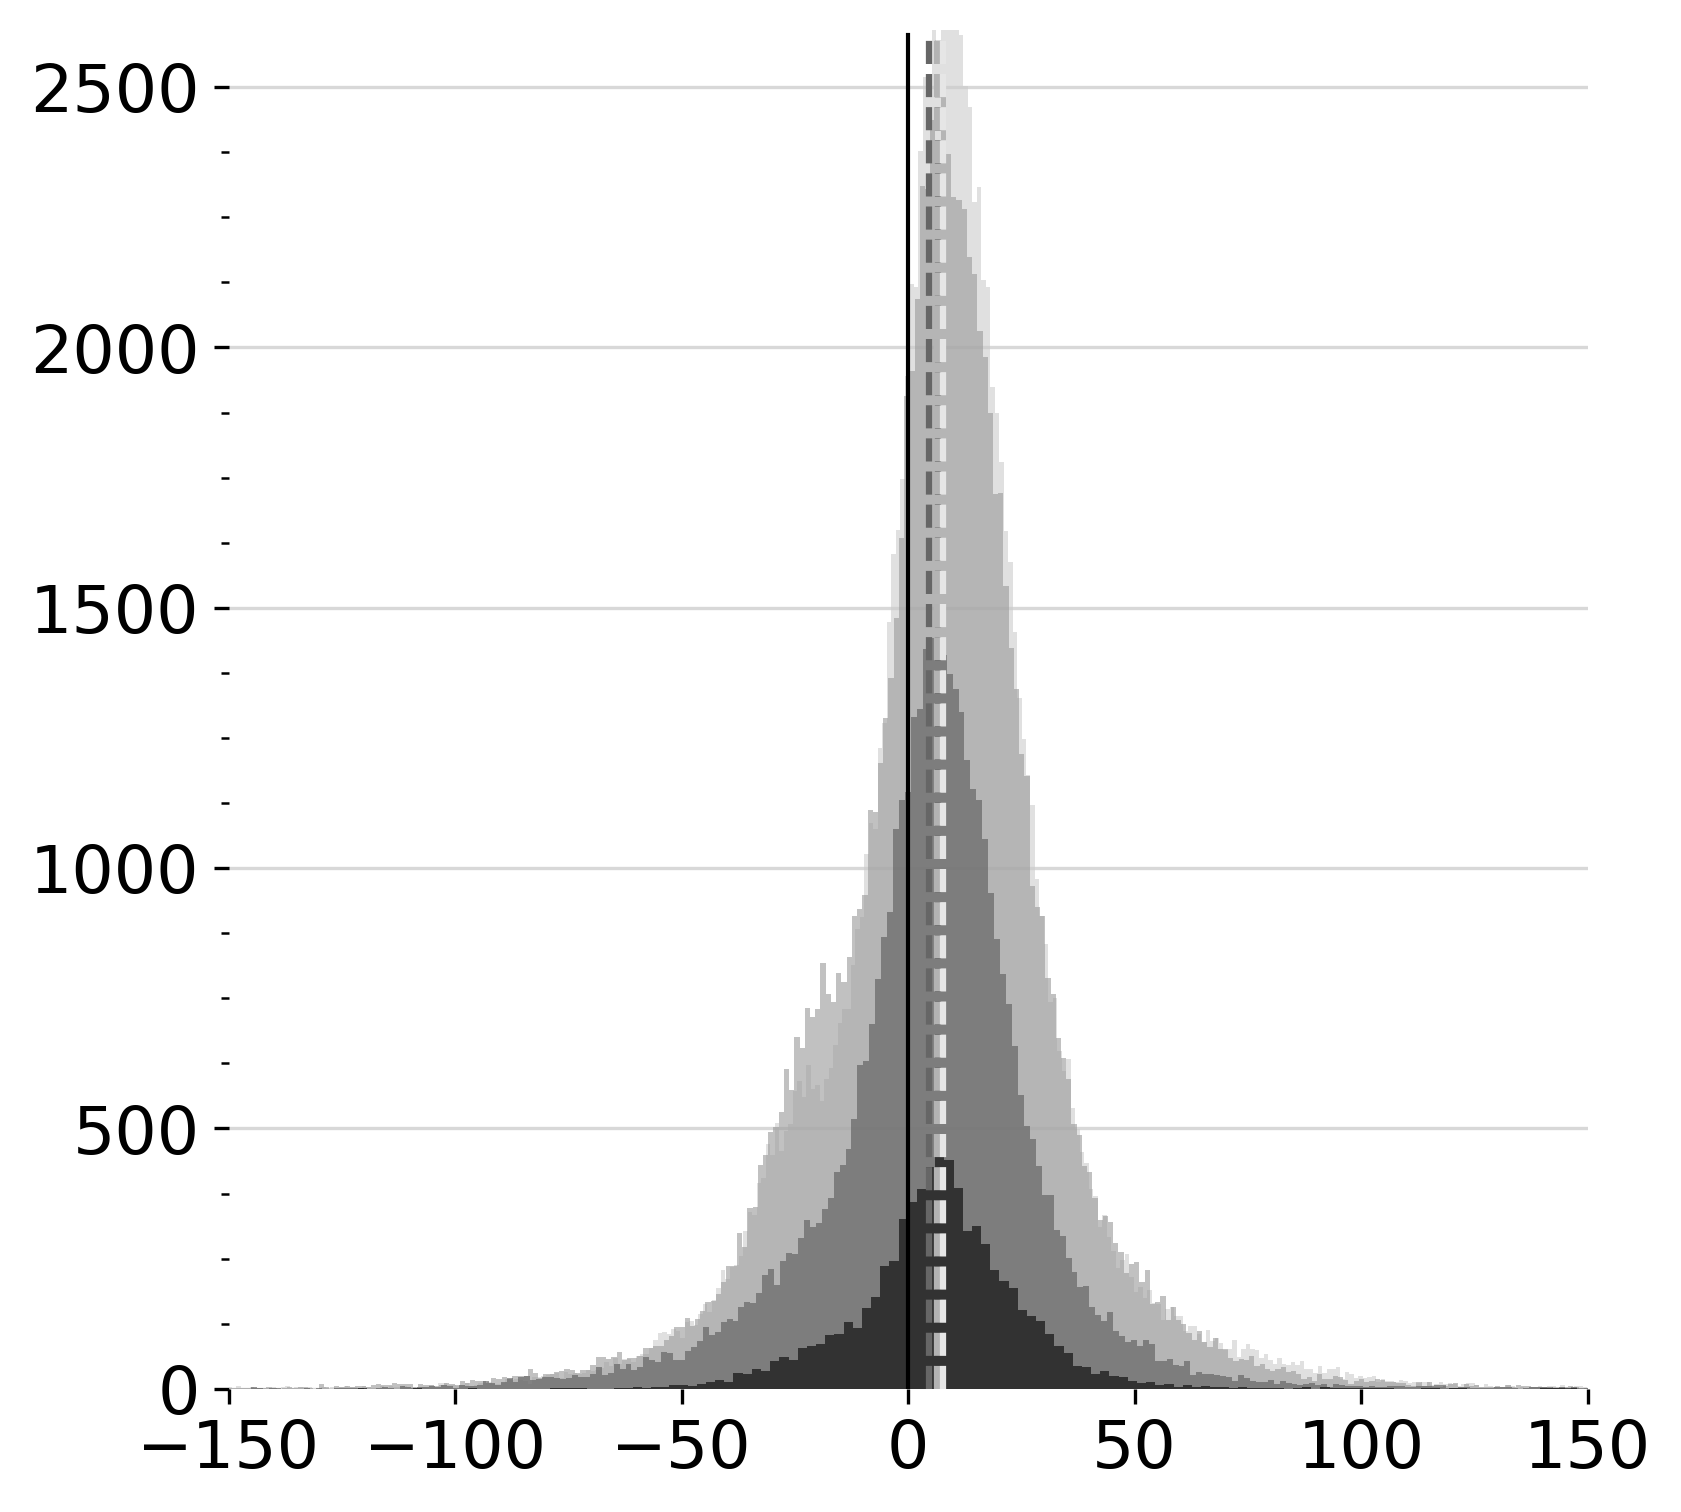

In [16]:
fig = plt.figure(figsize=(6,6)) 
ax = fig.add_subplot(111)


var = 'pco2'

ds_error_80s = ds_error.where((ds_soc[f'{var}']<800))
ds_error_80s = ds_error_80s.where((ds_error['time'].dt.year>=1980) & (ds_error['time'].dt.year<1990))
df_error_80s = ds_error_80s.to_dataset(name='data').to_dataframe().reset_index().dropna()

ds_error_90s = ds_error.where((ds_soc[f'{var}']<800))
ds_error_90s = ds_error_90s.where((ds_error['time'].dt.year>=1990) & (ds_error['time'].dt.year<2000))
df_error_90s = ds_error_90s.to_dataset(name='data').to_dataframe().reset_index().dropna()

ds_error_00s = ds_error.where((ds_soc[f'{var}']<800))
ds_error_00s = ds_error_00s.where((ds_error['time'].dt.year>=2000) & (ds_error['time'].dt.year<2010))
df_error_00s = ds_error_00s.to_dataset(name='data').to_dataframe().reset_index().dropna()

ds_error_10s = ds_error.where((ds_soc[f'{var}']<800))
ds_error_10s = ds_error_10s.where((ds_error['time'].dt.year>=2010) & (ds_error['time'].dt.year<2020))
df_error_10s = ds_error_10s.to_dataset(name='data').to_dataframe().reset_index().dropna()


# An "interface" to matplotlib.axes.Axes.hist() method

n, bins, patches = ax.hist(x=df_error_10s['data'], bins='auto', color=[0.8,0.8,0.8],
                            alpha=0.6, rwidth=1)

n, bins, patches = ax.hist(x=df_error_00s['data'], bins='auto', color=[0.6,0.6,0.6],
                            alpha=0.6, rwidth=1)

n, bins, patches = ax.hist(x=df_error_90s['data'], bins='auto', color=[0.35,0.35,0.35],
                            alpha=0.6, rwidth=1)


n, bins, patches = ax.hist(x=df_error_80s['data'], bins='auto', color=[0,0,0],
                            alpha=0.6, rwidth=1)





maxfreq = 2600 #n.max()


ax.plot([df_error_80s['data'].mean(), df_error_80s['data'].mean()],
         [0, maxfreq], color=[0,0,0], linestyle='--')
ax.plot([df_error_90s['data'].mean(), df_error_90s['data'].mean()],
         [0, maxfreq], color=[0.4,0.4,0.4], linestyle='--')
ax.plot([df_error_00s['data'].mean(), df_error_00s['data'].mean()],
         [0, maxfreq], color=[0.7,0.7,0.7], linestyle='--')
ax.plot([df_error_10s['data'].mean(), df_error_10s['data'].mean()],
         [0, maxfreq], color=[0.9,0.9,0.9], linestyle='--')

ax.plot([0, 0],[0, maxfreq], color=[0,0,0], linestyle='-', linewidth=1)

#n, bins, patches = plt.hist(x=df_out['fco2_ave_unwtd'], bins='auto', color='red', 
#                            alpha=0.5, rwidth=1)
ax.grid(axis='y', alpha=0.75)
#plt.xlabel('Value')
#plt.ylabel('Frequency')
#plt.title('My Very Own Histogram')
#plt.text(23, 45, r'$\mu=15, b=3$')
# Set a clean upper y-axis limit.
ax.set_ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)
ax.set_xlim(-150,150)


# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# major/minor tick lines
#ax.minorticks_on()
ax.yaxis.set_minor_locator(AutoMinorLocator(4))
#ax.xaxis.set_minor_locator(AutoMinorLocator(4))
ax.grid(axis='y', which='major', color=[0.8,0.8,0.8], linestyle='-')

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom') #'bottom' 

# Make axis square
x0, x1 = ax.get_xlim()
y0, y1 = ax.get_ylim()
ax.set_aspect(abs(x1-x0)/abs(y1-y0))

# Don't allow the axis to be on top of your data
ax.set_axisbelow(True)

ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)

## difference in errors

In [58]:
ds_error_10s.mean()-ds_error_80s.mean()

<xarray.DataArray ()>
array(1.09792341)

# 5. Box-plot of errors

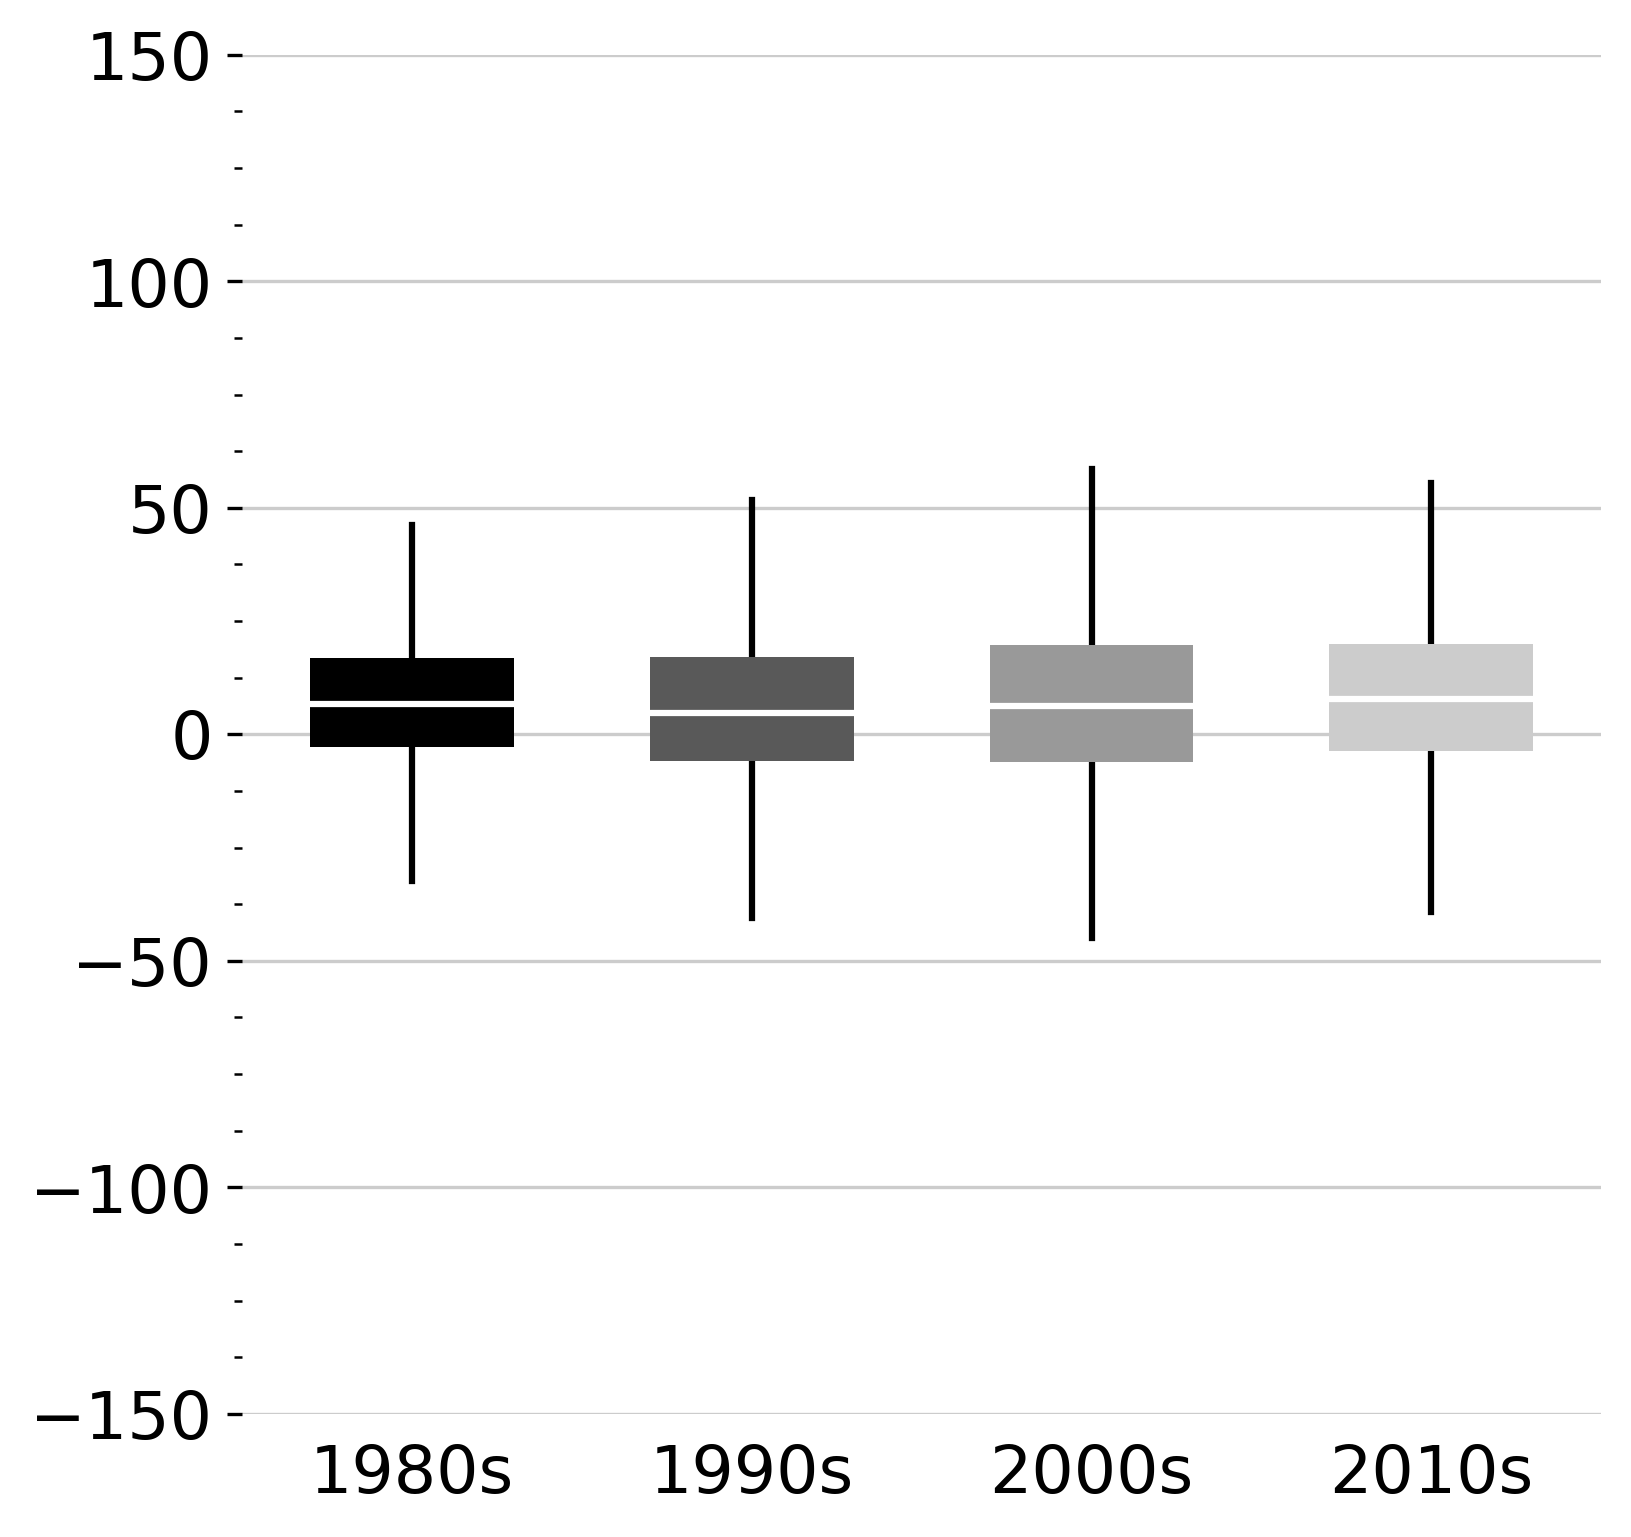

In [56]:
# https://www.delftstack.com/howto/matplotlib/how-to-set-tick-labels-font-size-in-matplotlib/
# https://jonchar.net/notebooks/matplotlib-styling/
# https://cduvallet.github.io/posts/2018/03/boxplots-in-python

# t test: https://www.statology.org/two-sample-t-test-python/
# https://www.machinelearningplus.com/plots/top-50-matplotlib-visualizations-the-master-plots-python/

#with plt.rc_context({'axes.edgecolor':'orange'}):
fig = plt.figure(figsize=(6,6)) 
ax = fig.add_subplot(111)

whiskerprops = {'linewidth':1.5, 'color': [0,0,0]}
boxprops = {'linewidth':0, 'color': [0.5,0.5,0.5]}
flierprops = {'marker':'o', 'markersize':3, 'markeredgecolor':[0.5,0.5,0.5], 'markeredgewidth':0.5}
capprops = {'linewidth':1.5, 'color': [0.5,0.5,0.5]}
meanprops = {'linewidth':1.5, 'linestyle':'-', 'color': [1,1,1], }
medianprops = {'linewidth':0, 'color': [1,1,1],}

params = {
    'x': [df_error_80s['data'], df_error_90s['data'], df_error_00s['data'], df_error_10s['data']],
    'positions': [1,2,3,4],
    'labels': ['1980s','1990s','2000s','2010s'],
    'widths':0.6, 
    'notch':False,
    'whis':1.5,
    'meanline': True, 'showmeans': True,
    'patch_artist':True,
    'whiskerprops': whiskerprops,
    'boxprops': boxprops,
    'capprops': capprops, 'showcaps':False,
    'flierprops':flierprops, 'showfliers':False,
    'medianprops': medianprops,
    'meanprops':meanprops,
    }

bplot = ax.boxplot(**params)

# fill with colors
colors = [
    [0,0,0], 
    [0.35,0.35,0.35], 
    [0.6, 0.6, 0.6],
    [0.8, 0.8, 0.8],
    ]


for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)
        
# Range ov axes
ax.set_ylim([-150, 150])
#ax.set_xlim([datetime.date(2000, 1, 1), datetime.date(2020, 12, 31)])

# Turn off the display of all ticks.
ax.tick_params(which='both', # Options for both major and minor ticks
                top='off', # turn off top ticks
                left='off', # turn off left ticks
                right='off',  # turn off right ticks
                bottom='off') # turn off bottom ticks

# rotate x tick labels
#plt.setp(ax.get_xticklabels(), rotation=90)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# major/minor tick lines
#ax.minorticks_on()
ax.yaxis.set_minor_locator(AutoMinorLocator(4))
#ax.xaxis.set_minor_locator(AutoMinorLocator(4))
ax.grid(axis='y', which='major', color=[0.8,0.8,0.8], linestyle='-')

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('none') #'bottom' 

# Make axis square
x0, x1 = ax.get_xlim()
y0, y1 = ax.get_ylim()
ax.set_aspect(abs(x1-x0)/abs(y1-y0))

# Don't allow the axis to be on top of your data
ax.set_axisbelow(True)

ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)

# Labels
#ax.set_ylabel(f'LAI', fontsize=16)


#dir_figs = '/rigel/glab/users/ljg2157/projects/heatwave/reports/figures'
#plt.savefig(f'{dir_figs}/boxplots.pdf', 
#                transparent = True, 
#                bbox_inches = 'tight', 
#                pad_inches = 0)

In [60]:
print(f'1980s {len(df_error_80s)}')
print(f'1990s {len(df_error_90s)}')
print(f'2000s {len(df_error_00s)}')
print(f'2010s {len(df_error_10s)}')

1980s 7237
1990s 43079
2000s 90583
2010s 108923


# Trash

In [ ]:
import scipy.stats as stats

# # this means we can assume equat variance 
print(df_soc_00s['pco2'].var()/df_soc_90s['pco2'].var())

#perform two sample t-test with equal variances
stats.ttest_ind(a=df_soc_80s['pco2'].values, 
                b=df_soc_90s['pco2'].values, 
                equal_var=True)